In [16]:
import os
os.getcwd()
import pandas as pd
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind, pearsonr, chi2_contingency, skew
from sklearn.model_selection import train_test_split
from statsmodels.miscmodels.ordinal_model import OrderedModel


In [ ]:
survey = pd.read_excel("survey.xlsx")
survey=survey[survey['included']==1]

In [4]:
#columns_to_check_time = [
#      'time spend on all social media apps actual', 'Instagram actual',
#       'TikTok actual', 'FB actual', 'whatsApp actual', 'LinkedIn actual',
#       'Twitter actual', 'Youtube actual', 'Snapchat actual', 'Threads actual',
#       'Pinterest actual', 'other actual']
columns_to_check_time = [
       'time spend on all social media apps actual']
# Calculate Z-score for the selected columns
z_scores_time = np.abs(stats.zscore(survey[columns_to_check_time]))

# Define a threshold for outliers (e.g., z-score > 3)
threshold = 3

# Create a mask to filter out rows with outliers in any of the selected columns
outlier_mask_time = (z_scores_time > threshold).any(axis=1)

# Filter out rows with outliers
df_cleaned = survey[~outlier_mask_time]
df_cleaned = df_cleaned.reset_index(drop=True)

# Initialize the 'outliers' column to 0
survey['outliers'] = 0

# Update the 'outliers' column in the original DataFrame based on the filtered DataFrame's outlier_mask
survey.loc[survey.index, 'outliers'] = np.where(outlier_mask_time, 1, 0)

# print the number of outliers detected
num_outliers = outlier_mask_time.sum()
print(f'Number of outliers detected: {num_outliers}')

# Display the DataFrame to verify
print(survey.head())
survey = survey[survey['outliers'] == 0]

Number of outliers detected: 2
   included   IDkoda  not equal            t_insert              t_edit  \
5         1  487grfa          0 2024-05-29 10:13:01 2024-05-29 10:21:04   
6         1  731gkam          0 2024-05-29 10:13:02 2024-05-29 10:20:05   
7         1   705fml          0 2024-05-29 10:13:03 2024-05-29 10:22:24   
8         1  67bemf5          0 2024-05-29 10:13:04 2024-05-29 10:22:02   
9         1  001mgan          1 2024-05-29 10:13:05 2024-05-29 10:23:43   

   status  SEX  AGE   Q2   Q3  ...  FB actual  whatsApp actual  \
5       6    2   23  0.0  0.0  ...         23                0   
6       6    2   22  0.0  0.0  ...          0                0   
7       6    2   22  0.0  0.0  ...         21                0   
8       6    1   22  0.0  0.0  ...         57                0   
9       6    2   22  0.0  0.0  ...         26                4   

   LinkedIn actual  Twitter actual  Youtube actual  Snapchat actual  \
5                0               0               0

In [5]:
# transforming risk taking outcomes into just one variable for lotteries, to see if we find some siginifcant resutls
# Create a risk-taking variable
lotteries = ['Q2','Q3','Q4','Q5']
def classify_risk_taking(row):
    num_risky = sum(row[col] == 1 for col in lotteries)
    num_safe = sum(row[col] == 0 for col in lotteries)
    if num_risky > num_safe:
        return 1  # Risk-taking
    elif num_safe > num_risky:
        return -1   # Risk-averse
    else:
        return 0  # Neutral

survey['risk_taking'] = survey.apply(classify_risk_taking, axis=1)

survey['sum_r'] = survey[lotteries].sum(axis=1)

# Risk-taking framing effect from scenarios 
scenarios_columns = [ 'Q8', 'Q9', 'Q7a', 'Q7b']
def classify_framing(row):
    num_risky = sum(row[col] == 1 for col in scenarios_columns)
    num_safe = sum(row[col] == 0 for col in scenarios_columns)
    if num_risky == 2:
        return 0  
    elif num_safe == 2:
        return 0   
    else:
        return 1   
    
    
survey['framing'] = survey.apply(classify_framing, axis=1)

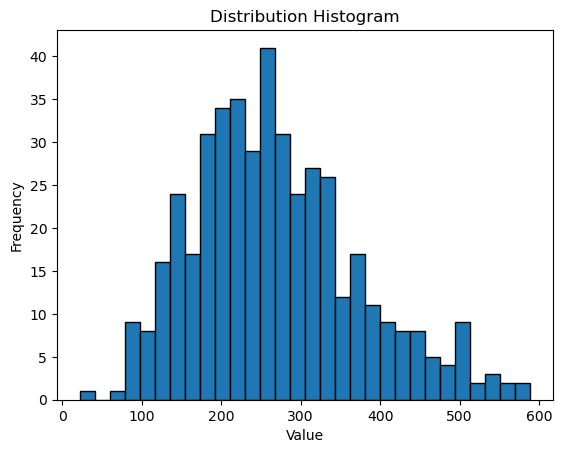

Chi-square statistic: 10.389583487192223, p-value: 0.03435241881913883


In [6]:
# Create the histogram
plt.hist(survey['time spend on all social media apps actual'], bins=30, edgecolor='black')
plt.title('Distribution Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Define percentiles
tercile1 = survey['time spend on all social media apps actual'].quantile(0.33)
tercile2 = survey['time spend on all social media apps actual'].quantile(0.66)

# Create the new variable
def categorize_usage(minutes):
    if minutes <= tercile1:
        return 0
    elif minutes <= tercile2:
        return 1
    else:
        return 2

survey['social_media_group'] = survey['time spend on all social media apps actual'].apply(categorize_usage)
# Create contingency table for risk-taking and social media usage
contingency_table = pd.crosstab(survey['risk_taking'], survey['social_media_group'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")


In [37]:
# Create contingency table for framing risk-taking and social media usage
contingency_framing_table = pd.crosstab(survey['framing'], survey['social_media_group'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_framing_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")

Chi-square statistic: 2.275091774771616, p-value: 0.3206048575823326


In [38]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X = survey[['social_media_group', 'SEX', 'AGE']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model_TERCILE = OrderedModel(y, X, distr='logit')
result_TERCILE = model_TERCILE.fit(method='bfgs')

# Display the summary
print(result_TERCILE.summary())

Optimization terminated successfully.
         Current function value: 0.997092
         Iterations: 24
         Function evaluations: 29
         Gradient evaluations: 29
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -444.70
Model:                   OrderedModel   AIC:                             899.4
Method:            Maximum Likelihood   BIC:                             919.9
Date:                Mon, 09 Sep 2024                                         
Time:                        13:46:30                                         
No. Observations:                 446                                         
Df Residuals:                     441                                         
Df Model:                           3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [7]:
# Create the new variable
def categorize_usage(minutes):
    if minutes <= 200: #190,150
        return 0
    elif minutes <= 270: #270
        return 1
    else:
        return 2

survey['social_media_group'] = survey['time spend on all social media apps actual'].apply(categorize_usage)
# Create contingency table for risk-taking and social media usage
contingency_table = pd.crosstab(survey['risk_taking'], survey['social_media_group'])

# Perform Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, p-value: {p}")



Chi-square statistic: 13.01895021963614, p-value: 0.011183570037573807


In [43]:
# at the end i did not use this
# #definding a new variable that sums upp social media apps
# columns_to_sum = [
#     'Instagram actual', 'TikTok actual', 'Youtube actual','FB actual', 'whatsApp actual',
#     'LinkedIn actual', 'Twitter actual', 
#     'Snapchat actual', 'Threads actual', 'Pinterest actual'
# ]

# # Create a new column 'sum_sm' by summing the specified columns
# survey['sum_sm'] = survey[columns_to_sum].sum(axis=1)
# survey['sum_sm_top'] = survey[(columns_to_sum[0:2])].sum(axis=1)

In [11]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X_ordered = survey[['social_media_group', 'SEX','framing']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model_ordered = OrderedModel(y, X_ordered, distr='logit')
result_ordered = model_ordered.fit(method='bfgs')

# Display the summary
print(result_ordered.summary())

Optimization terminated successfully.
         Current function value: 0.996656
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -444.51
Model:                   OrderedModel   AIC:                             899.0
Method:            Maximum Likelihood   BIC:                             919.5
Date:                Thu, 17 Oct 2024                                         
Time:                        12:41:31                                         
No. Observations:                 446                                         
Df Residuals:                     441                                         
Df Model:                           3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [12]:
# Prepare data
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
X = survey[['time spend on all social media apps actual', 'SEX','AGE']] #WITH SOCIAL_MEDIA_GROUP BETTER P VALUES AND COEFF
y = survey['risk_taking']

# Add constant term for the intercept
X = sm.add_constant(X)

# Fit multinomial logistic regression model
mnlogit_model = sm.MNLogit(y, X).fit()
print(mnlogit_model.summary())

Optimization terminated successfully.
         Current function value: 0.990270
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:            risk_taking   No. Observations:                  446
Model:                        MNLogit   Df Residuals:                      438
Method:                           MLE   Df Model:                            6
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                 0.02189
Time:                        12:41:33   Log-Likelihood:                -441.66
converged:                       True   LL-Null:                       -451.54
Covariance Type:            nonrobust   LLR p-value:                  0.003047
                             risk_taking=0       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       

In [13]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
survey['SA'] = survey['AGE'] * survey['framing']
X_continuous = survey[['time spend on all social media apps actual','SEX','framing']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model_continuous = OrderedModel(y, X_continuous, distr='logit')
result_continuous = model_continuous.fit(method='bfgs')

# Display the summary
print(result_continuous.summary())




Optimization terminated successfully.
         Current function value: 0.994556
         Iterations: 19
         Function evaluations: 24
         Gradient evaluations: 24
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -443.57
Model:                   OrderedModel   AIC:                             897.1
Method:            Maximum Likelihood   BIC:                             917.6
Date:                Thu, 17 Oct 2024                                         
Time:                        12:41:36                                         
No. Observations:                 446                                         
Df Residuals:                     441                                         
Df Model:                           3                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
------

In [46]:
# Calculate marginal effects

# Choose the variable for which you want to calculate the marginal effect (e.g., 'time spend on all social media apps actual')
selected_variable = 'time spend on all social media apps actual'

# Step 1: Predict probabilities for each category
predicted_probs = result_continuous.predict(X_continuous, which='prob')

# Get the coefficient for the selected variable
selected_coefficient = result_continuous.params[selected_variable]

# Calculate the marginal effects for each observation
# Using the formula: predicted_probs * (1 - predicted_probs) * coefficient
marginal_effects = np.sum(predicted_probs * (1 - predicted_probs) * selected_coefficient, axis=1)

# Compute the average marginal effect across all observations
average_marginal_effect = np.mean(marginal_effects)

print(f'Average Marginal Effect for {selected_variable}: {average_marginal_effect}')



Average Marginal Effect for time spend on all social media apps actual: 0.001100960313691645


In [14]:
# Prepare data for ordinal logistic regression
survey['log_social_media_time'] = np.log(survey['time spend on all social media apps actual'])
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
survey['SA'] = survey['AGE'] * survey['log_social_media_time']
survey['SX'] = survey['SEX'] * survey['log_social_media_time']

X_continuous_log = survey[['log_social_media_time','SEX','framing']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model_continuous_log = OrderedModel(y, X_continuous_log, distr='logit')
result_continuous_log = model_continuous_log.fit(method='bfgs')

# Display the summary
print(result_continuous_log.summary())


Optimization terminated successfully.
         Current function value: 0.994900
         Iterations: 23
         Function evaluations: 24
         Gradient evaluations: 24
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -443.73
Model:                   OrderedModel   AIC:                             897.5
Method:            Maximum Likelihood   BIC:                             918.0
Date:                Thu, 17 Oct 2024                                         
Time:                        12:41:43                                         
No. Observations:                 446                                         
Df Residuals:                     441                                         
Df Model:                           3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [23]:
# Compute log-likelihood for the null model

counts = y.value_counts()
proportions = counts / len(y)
# Log-likelihood of the null model
null_ll = np.sum([np.sum(y == k) * np.log(proportions[k]) for k in proportions.index])

# Log-likelihood for the fitted model
log_likelihood_fitted = result_continuous.llf

# Compute McFadden’s R^2
mcfadden_r2 = 1 - (log_likelihood_fitted / null_ll)
print(f"McFadden's R^2: {mcfadden_r2:.4f}")

McFadden's R^2: 0.0186


In [16]:

# Coefficients from the model
coef_time_spent = 0.47
coef_sex = -0.476
coef_framing = -0.3044
coef_age = -0.1659

# Extract the relevant columns from the dataframe
time_spent = survey['log_social_media_time']
sex = survey['SEX']
framing = survey['framing']
age= survey['AGE']

# Compute the latent variable z for each observation
z_values = coef_time_spent * time_spent + coef_sex * sex + coef_framing * framing+ age *coef_age

# Calculate the minimum and maximum z values
min_z = z_values.min()
max_z = z_values.max()

print(f"Minimum z value: {min_z}")
print(f"Maximum z value: {max_z}")


Minimum z value: -2.978556770760851
Maximum z value: -0.9495180906055238


In [432]:
# Prepare data for ordinal logistic regression
survey['social_media_group'] = survey['social_media_group'].astype('category').cat.codes
survey['SA'] = survey['AGE'] * survey['risk_taking']
X_continuous_f = survey[['time spend on all social media apps actual','risk_taking','AGE']]
y = survey['framing']

# Add a constant term to the independent variables
X_continuous_f = sm.add_constant(X_continuous_f)

# Fit the logistic regression model
model_continuous_f = sm.Logit(y, X_continuous_f)
result_continuous_f = model_continuous_f.fit(method='bfgs')

# Display the summary
print(result_continuous_f.summary())

Optimization terminated successfully.
         Current function value: 0.642944
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28
                           Logit Regression Results                           
Dep. Variable:                framing   No. Observations:                  446
Model:                          Logit   Df Residuals:                      442
Method:                           MLE   Df Model:                            3
Date:                Thu, 15 Aug 2024   Pseudo R-squ.:                0.008853
Time:                        16:30:31   Log-Likelihood:                -286.75
converged:                       True   LL-Null:                       -289.31
Covariance Type:            nonrobust   LLR p-value:                    0.1630
                                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [409]:
# Define the predictors and the dependent variable
X_continuous = survey[['time spend on all social media apps actual', 'SEX', 'AGE']]
y = survey['sum_r']

# Add a constant to the predictors (this adds the intercept to the model)
X_continuous = sm.add_constant(X_continuous)

# Fit the Poisson regression model
model_poisson = sm.GLM(y, X_continuous, family=sm.families.Poisson()).fit()

# Display the summary
print(model_poisson.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  sum_r   No. Observations:                  372
Model:                            GLM   Df Residuals:                      368
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -541.73
Date:                Thu, 15 Aug 2024   Deviance:                       250.82
Time:                        16:24:25   Pearson chi2:                     185.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.02025
Covariance Type:            nonrobust                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [19]:
# Convert 'SEX' to categorical codes if it's not already
survey['SEX'] = survey['SEX'].astype('category').cat.codes
survey['sm'] = survey['framing'] * survey['AGE']
survey['SA'] = survey['SEX'] * survey['time spend on all social media apps actual']
# Prepare the features (X) and the target (y)
X = survey[['time spend on all social media apps actual', 'SEX','SA']]
y = survey['risk_taking']

# Fit the ordinal logistic regression model
model_inter = OrderedModel(y, X, distr='logit')
result_inter = model_inter.fit(method='bfgs')

# Display the summary
print(result_inter.summary())

Optimization terminated successfully.
         Current function value: 0.993709
         Iterations: 21
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -442.20
Model:                   OrderedModel   AIC:                             894.4
Method:            Maximum Likelihood   BIC:                             914.9
Date:                Wed, 21 Aug 2024                                         
Time:                        06:55:40                                         
No. Observations:                 445                                         
Df Residuals:                     440                                         
Df Model:                           3                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
------

In [17]:
# Compare models using AIC and BIC
print(f"Ordered Model AIC: {result_ordered.aic}, BIC: {result_ordered.bic}")
print(f"Continuous Model AIC: {result_continuous.aic}, BIC: {result_continuous.bic}")

# Log-Likelihood comparison
print(f"Ordered Model Log-Likelihood: {result_ordered.llf}")
print(f"Continuous Model Log-Likelihood: {result_continuous.llf}")

# Pseudo R-squared calculation
def pseudo_r2(llf, llf_null):
    return 1 - (llf / llf_null)

# Use the log-likelihood of the null model for comparison
llf_null = np.log(y.value_counts().max() / len(y)) * len(y)  # Log-likelihood of a null model with the most frequent class
pseudo_r2_ordered = pseudo_r2(result_ordered.llf, llf_null)
pseudo_r2_continuous = pseudo_r2(result_continuous.llf, llf_null)

print(f"Ordered Model Pseudo R-squared: {pseudo_r2_ordered}")
print(f"Continuous Model Pseudo R-squared: {pseudo_r2_continuous}")

# Train-test split for accuracy comparison
X_ordered_train, X_ordered_test, y_train, y_test = train_test_split(X_ordered, y, test_size=0.2, random_state=42)
X_continuous_train, X_continuous_test, y_train, y_test = train_test_split(X_continuous, y, test_size=0.2, random_state=42)

# Fit models for accuracy evaluation
model_ordered_cv = OrderedModel(y_train, X_ordered_train, distr='logit').fit(method='bfgs', disp=False)
model_continuous_cv = OrderedModel(y_train, X_continuous_train, distr='logit').fit(method='bfgs', disp=False)

# Predict and convert probabilities to class labels
def predict_classes(model, X):
    # Get predicted probabilities
    probs = model.predict(X)
    # Convert probabilities to class labels
    return np.argmax(probs, axis=1)

# Predict and calculate accuracy
y_pred_ordered = predict_classes(model_ordered_cv, X_ordered_test)
y_pred_continuous = predict_classes(model_continuous_cv, X_continuous_test)
accuracy_ordered = accuracy_score(y_test, y_pred_ordered)
accuracy_continuous = accuracy_score(y_test, y_pred_continuous)

print(f"Ordered Model Accuracy: {accuracy_ordered}")
print(f"Continuous Model Accuracy: {accuracy_continuous}")

Ordered Model AIC: 899.017128915693, BIC: 919.5187236757934
Continuous Model AIC: 897.1441357502049, BIC: 917.6457305103053
Ordered Model Log-Likelihood: -444.5085644578465
Continuous Model Log-Likelihood: -443.57206787510245
Ordered Model Pseudo R-squared: -0.4378706313363392
Continuous Model Pseudo R-squared: -0.43484130627863915
Ordered Model Accuracy: 0.23333333333333334
Continuous Model Accuracy: 0.2222222222222222


In [434]:
# Convert 'SEX' to categorical codes 
survey['SEX'] = survey['SEX'].astype('category').cat.codes
survey['gender_sm'] = survey['SEX'] * survey['social_media_group']
survey['SA'] = survey['SEX'] * survey['risk_taking']
# Prepare the features (X) and the target (y)
X = survey[['risk_taking', 'SEX','AGE','framing']]
y = survey['social_media_group']

# Fit the ordinal logistic regression model
model_sm = OrderedModel(y, X, distr='logit')
result_sm = model_sm.fit(method='bfgs')

# Display the summary
print(result_sm.summary())

Optimization terminated successfully.
         Current function value: 1.068271
         Iterations: 28
         Function evaluations: 33
         Gradient evaluations: 33
                             OrderedModel Results                             
Dep. Variable:     social_media_group   Log-Likelihood:                -476.45
Model:                   OrderedModel   AIC:                             964.9
Method:            Maximum Likelihood   BIC:                             989.5
Date:                Thu, 15 Aug 2024                                         
Time:                        16:31:14                                         
No. Observations:                 446                                         
Df Residuals:                     440                                         
Df Model:                           4                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

In [435]:
# Social media as dependant in lienar regression

X = survey[['risk_taking', 'SEX','AGE','framing']]
y = survey['time spend on all social media apps actual']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                                        OLS Regression Results                                        
Dep. Variable:     time spend on all social media apps actual   R-squared:                       0.019
Model:                                                    OLS   Adj. R-squared:                  0.010
Method:                                         Least Squares   F-statistic:                     2.100
Date:                                        Thu, 15 Aug 2024   Prob (F-statistic):             0.0799
Time:                                                16:31:21   Log-Likelihood:                -2701.2
No. Observations:                                         446   AIC:                             5412.
Df Residuals:                                             441   BIC:                             5433.
Df Model:                                                   4                                         
Covariance Type:                                    nonrobust            

In [346]:
# Convert 'SEX' to categorical codes 
survey['SEX'] = survey['SEX'].astype('category').cat.codes
survey['gender_sm'] = survey['SEX'] * survey['social_media_group']
survey['SA'] = survey['SEX'] * survey['risk_taking']
# Prepare the features (X) and the target (y)
X = survey[['risk_taking', 'SEX','AGE','framing']]
y = survey['social_media_group']

# Fit the ordinal logistic regression model
model_sm = OrderedModel(y, X, distr='logit')
result_sm = model_sm.fit(method='bfgs')

# Display the summary
print(result_sm.summary())

Optimization terminated successfully.
         Current function value: 1.066838
         Iterations: 28
         Function evaluations: 33
         Gradient evaluations: 33
                             OrderedModel Results                             
Dep. Variable:     social_media_group   Log-Likelihood:                -477.94
Model:                   OrderedModel   AIC:                             967.9
Method:            Maximum Likelihood   BIC:                             992.5
Date:                Thu, 15 Aug 2024                                         
Time:                        11:17:19                                         
No. Observations:                 448                                         
Df Residuals:                     442                                         
Df Model:                           4                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

In [347]:
baseline_accuracy = y.value_counts().max() / len(y)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Model Accuracy: {accuracy:.4f}")
print(f"Improvement: {accuracy - baseline_accuracy:.4f}")

cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

print(classification_report(y, y_pred))

Baseline Accuracy: 0.4286
Model Accuracy: 0.9487
Improvement: 0.5201
Confusion Matrix:
[[ 46  25  51]
 [ 63  19  52]
 [118  27  47]]
              precision    recall  f1-score   support

           0       0.20      0.38      0.26       122
           1       0.27      0.14      0.19       134
           2       0.31      0.24      0.27       192

    accuracy                           0.25       448
   macro avg       0.26      0.25      0.24       448
weighted avg       0.27      0.25      0.25       448



model is performing exactly the same as the baseline model, which simply predicts the most common class every time.

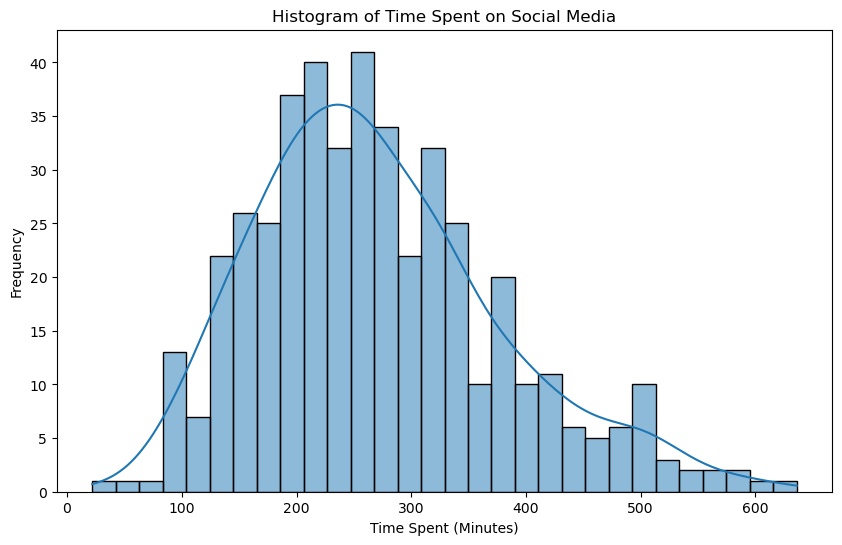

Skewness: 0.68


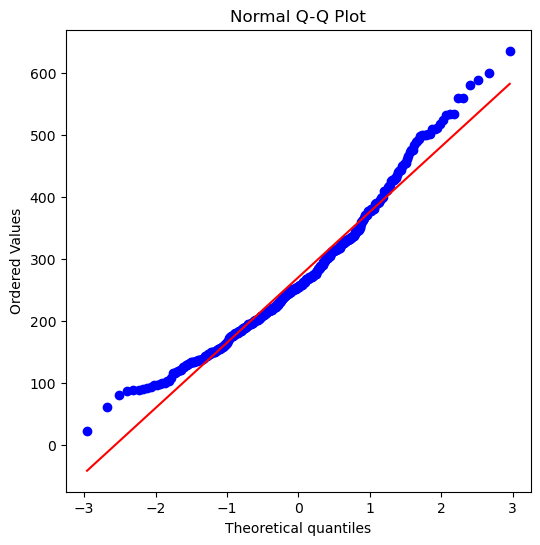

In [3]:
# 1. Visual Inspection: Histogram
plt.figure(figsize=(10, 6))
sns.histplot(survey['time spend on all social media apps actual'], kde=True, bins=30)
plt.title('Histogram of Time Spent on Social Media')
plt.xlabel('Time Spent (Minutes)')
plt.ylabel('Frequency')
plt.show()

# 2. Skewness Statistic
skewness_value = skew(survey['time spend on all social media apps actual'])
print(f'Skewness: {skewness_value:.2f}')

# 3. Normal Q-Q Plot

plt.figure(figsize=(6, 6))
stats.probplot(survey['time spend on all social media apps actual'], dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()